In [1]:
import json, ast

In [3]:
# import the required libraries
import numpy as np
import time
import random
import pickle
import codecs
import collections
import os
import copy
import math
import json
import tensorflow as tf
from six.moves import xrange
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *
# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

# Exploring stroke data from a-painter

In [4]:
filename = "paintings/circle.json"

In [5]:
f = open(filename, 'r')
s = ''.join([line.strip() for line in f])
t = json.loads(s)
drawing = ast.literal_eval(json.dumps(t)) # to remove unicode identifiers
f.close()

In [6]:
#TODO: add smoothing
prev_pos = random.uniform(-0.01, 0.01)
for i in range(len(drawing['strokes'])): # go per stroke
    lst = [random.uniform(-1,1)] * 4 # for a particular stroke, I want all orientation to be the same
    prev_pos = prev_pos + random.uniform(-0.001, 0.001)
    for j in range(len(drawing['strokes'][i]['points'])): # go per point in that stroke
        drawing['strokes'][i]['points'][j]['position'][2] = prev_pos 
        for k in range(len(drawing['strokes'][i]['points'][j]['orientation'])):
            drawing['strokes'][i]['points'][j]['orientation'][k] = lst[k] + random.uniform(-0.001,0.001) # very subtle difference to account for hand movement!
        
        

In [7]:
f2 = open('paintings/orientation_0.json', 'w')
f2.write(json.dumps(drawing))
f2.close()

# SketchRNN input-output

In [8]:
# !curl http://localhost:8080/simple_predict?strokes=[[1,2,1,0,0],[4,19,1,0,0],[19,27,1,0,0],[17,8,1,0,0],[28,0,1,0,0],[12,-7,1,0,0],[14,-15,1,0,0],[10,-26,1,0,0],[0,-18,1,0,0],[-5,-13,1,0,0],[-11,-13,1,0,0],[-20,-9,1,0,0],[-14,0,1,0,0],[-42,18,1,0,0],[-11,15,1,0,0],[-2,15,0,1,0]]

In [9]:
inp = [[1,2,1,0,0],[4,19,1,0,0],[19,27,1,0,0],[17,8,1,0,0],[28,0,1,0,0],[12,-7,1,0,0],[14,-15,1,0,0],[10,-26,1,0,0],[0,-18,1,0,0],[-5,-13,1,0,0],[-11,-13,1,0,0],[-20,-9,1,0,0],[-14,0,1,0,0],[-42,18,1,0,0],[-11,15,1,0,0],[-2,15,0,1,0]]
a = [[30.898920864937615,-26.35934265471446,1,0,0],[-5.099672214043287,2.2108907999543406,1,0,0],[-16.008301775063913,4.04690987864689,1,0,0],[-22.79240956110664,4.357734420450489,1,0,0],[-8.837910599253819,0.8209950993707161,1,0,0],[-12.703100171799573,0.9206469064553269,1,0,0],[-8.21713163227863,-0.30323306371954534,1,0,0],[-2.0681587699553536,-0.2546194442409226,1,0,0],[6.136905942118358,2.728229886055356,1,0,0],[20.660192226559136,6.39281764774201,1,0,0],[14.449655190078067,3.2274631458635077,1,0,0],[22.658688279584148,2.71098646507703,1,0,0],[8.182476463534584,0.5014385863932643,1,0,0],[5.148631499451467,-0.7527492360465403,1,0,0],[3.830544111877615,-1.7805762191767374,0,1,0],[-29.64752394401306,4.216097644224086,1,0,0],[-0.13202259468132127,1.6819374624459245,1,0,0],[1.5585793710976925,4.45843143680448,1,0,0],[8.550353416063592,13.980432644698014,1,0,0],[11.13277492648355,10.806515956700027,1,0,0],[12.061890625365299,6.3838232723587565,1,0,0],[11.773008723646479,3.785044530984849,1,0,0],[14.4697176639171,1.5090718939212802,1,0,0],[13.070083032260714,-2.8367884978811198,1,0,0],[7.718895150158861,-3.3657940581297443,1,0,0],[3.3851620909045224,-2.8800212539895047,1,0,0],[2.8805504540975146,-4.118059745795224,1,0,0],[2.4484212580991374,-5.760428109085627,1,0,0],[2.015590842925309,-18.235349821292726,1,0,0],[-0.605351024917613,-6.012789242046778,1,0,0],[-2.9342094997157875,-7.778284919102001,1,0,0],[-6.980330809866045,-10.596387810933779,1,0,0],[-7.245679246533599,-6.4120594193660425,1,0,0],[-6.407642276317707,-3.58063676238477,1,0,0],[-7.406692122146148,-2.4472878348480176,0,1,0],[27.73442429883432,11.379365104805998,1,0,0],[2.246160964940122,-2.224485126667086,1,0,0],[15.939433880911354,-9.987457664298947,1,0,0],[5.496215972722529,-2.534531608027964,1,0,0],[17.400888672515116,-8.609377008083179,1,0,0],[1.906192961048273,1.057688844691271,1,0,0],[2.0205805356279147,5.853752109477814,1,0,0],[0.44027254204161154,5.160851385186609,1,0,0],[-2.0988092357467867,8.875872116047992,1,0,0],[-3.5499697606661185,7.04101118202722,1,0,0],[-17.637971218496997,16.562651420981883,1,0,0],[-5.171451659590991,2.370696920977975,0,1,0],[-74.62000772210547,29.80334128223452,1,0,0],[-3.0962317530435963,-0.4820813827987885,1,0,0],[-14.479480721622572,2.5089555530961607,1,0,0],[-6.189971740971962,1.9476202642955711,1,0,0],[-2.0599332592227713,1.8756641303819122,1,0,0],[-1.1465548574251916,2.6539116408445884,1,0,0],[0.01564822016417901,5.825985819504569,1,0,0],[1.4564234440172137,3.9314057616566966,1,0,0],[3.9143748098361706,4.885725185224288,1,0,0],[12.338942466610618,7.901572631381712,1,0,0],[20.661640381135363,3.3468668881386616,1,0,0],[10.176418540869907,-0.0004008009753693445,1,0,0],[3.8046538520377413,-0.5832969622582559,1,0,0],[2.8275192939517373,-1.5798591399211743,1,0,0],[2.1121976266527103,-2.591758747374942,1,0,0],[1.942918695235307,-5.841436866199436,1,0,0],[-0.18565984524039483,-6.739021904596517,0,1,0],[-9.808711235271806,5.049191196964791,1,0,0],[-3.044638604543274,18.93363388932704,1,0,0],[-3.6403251899707936,10.654336250262048,1,0,0],[-3.011246899732827,-0.5169732397269979,1,0,0],[-9.784867412853473,-1.6847022460976535,1,0,0],[-4.6108063155873005,0.16138480152716644,1,0,0],[-5.990020959481472,2.2131900084883456,1,0,0],[1.2773849540865294,2.693910582682969,1,0,0],[4.996736270655439,0.5136635285730268,1,0,0],[2.99703953362229,-0.5290098766334695,1,0,0],[7.881521093300306,-3.698287994238373,1,0,0],[4.001893581419237,-3.0172731394997068,1,0,0],[7.331290214947139,-3.1671191727790697,1,0,0],[2.6360404027679554,-0.20461337471035215,1,0,0],[2.8546795317063887,1.456198603188083,1,0,0],[0.500539140403837,1.8414225564910307,1,0,0],[0.1648420320877549,5.364175124439421,1,0,0],[-3.0637206709347744,9.276714859217439,1,0,0],[-0.8302325750951186,-11.878125611422702,1,0,0],[0.36157601695836117,-3.892917075956689,1,0,0],[1.645590689967298,-6.1848744557563125,1,0,0],[2.719012679876355,-2.9956546140034344,1,0,0],[6.92286977527566,-1.4159168169264005,1,0,0],[8.712905659026607,0.0008202611109713055,1,0,0],[10.767836982418013,3.269471487743751,1,0,0],[9.26768222259078,10.666649200035645,1,0,0],[4.354338268447038,2.947648948916624,1,0,0],[11.742105619700096,3.8282638519921406,1,0,0],[-2.305883131773883,0.4426749079254775,0,1,0],[-36.8631777541271,-19.4505618262822,0,0,1]]

In [10]:
import matplotlib.pyplot as plt
def draw_strokes(lst_strokes, last_x=283, last_y=281):
    i = 0
    xs = []
    ys = []
    num_strokes = 0
    stroke_point_count = []
    temp_count = 0
    while i < len(lst_strokes):
        if lst_strokes[i][3] != 1:
            xs.append(last_x - lst_strokes[i][0])
            ys.append(last_y - lst_strokes[i][1])
            last_x = xs [-1]
            last_y = ys [-1]
            temp_count += 1
        else:
            xs.append(last_x - lst_strokes[i][0])
            ys.append(last_y - lst_strokes[i][1])
            plt.plot(xs, ys)
            last_x = xs[-1]
            last_y = ys[-1]
            xs = []
            ys = []
            temp_count += 1
            stroke_point_count.append(temp_count)
            temp_count = 0
            num_strokes += 1
        i+=1 
    if len(xs) != 0:
        plt.plot(xs,ys)
        
    print(num_strokes)
    print(stroke_point_count)
    plt.show()
        
    

6
[16, 15, 20, 12, 17, 29]


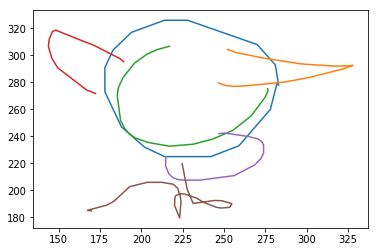

In [11]:
draw_strokes(inp+a)

# From a-painter to SketchRNN

In [12]:
filename = "paintings/circle.json"

In [13]:
f = open(filename, 'r')
s = ''.join([line.strip() for line in f])
t = json.loads(s)
drawing = ast.literal_eval(json.dumps(t)) # to remove unicode identifiers
f.close()


In [14]:
# sk_rnn = []
# uu = 0
# vv = 1

# for i in range(len(drawing['strokes'])): # go per stroke
#     last_x = drawing['strokes'][i]['points'][0]['position'][uu]
#     last_y = drawing['strokes'][i]['points'][0]['position'][vv]
#     po = drawing['strokes'][i]['points'][0]['position'][uu] - last_x
#     pi = drawing['strokes'][i]['points'][0]['position'][vv] - last_y
#     for j in range(1,len(drawing['strokes'][i]['points']), 10): # go per point in that stroke
#         sk_rnn.append( [0,0,0,0,0] )
#         sk_rnn[-1][2] = 1
#         sk_rnn[-1][0] = drawing['strokes'][i]['points'][j]['position'][uu] - last_x -po #dx 
#         sk_rnn[-1][1] = drawing['strokes'][i]['points'][j]['position'][vv] - last_y -pi #dy
#         po = sk_rnn[-1][0]
#         pi = sk_rnn[-1][1]
#     sk_rnn[-1][3] = 1
#     sk_rnn[-1][2] = 0
# print(sk_rnn)

In [15]:
# draw_strokes(sk_rnn) #direct plot does not work


In [16]:
# from dx,dy of sketch rnn to world coordinates! solely for the purpose of visualizing it in 3D!
sk_rnn0 = []
sk_rnn1 = []
sk_rnn2 = []
uu = 0
vv = 1
zz = 2
for i in range(len(drawing['strokes'])): # go per stroke
    l0 = drawing['strokes'][i]['points'][0]['position'][uu]
    l1 = drawing['strokes'][i]['points'][0]['position'][vv]
    l2 = drawing['strokes'][i]['points'][0]['position'][zz]
    for j in range(1,len(drawing['strokes'][i]['points'])): # go per point in that stroke
        sk_rnn0.append([0])
        sk_rnn1.append([0])
        sk_rnn2.append([0])
        sk_rnn2[-1] = drawing['strokes'][i]['points'][j]['position'][zz] - l2
        sk_rnn0[-1] = drawing['strokes'][i]['points'][j]['position'][uu] - l0
        sk_rnn1[-1] = drawing['strokes'][i]['points'][j]['position'][vv] - l1

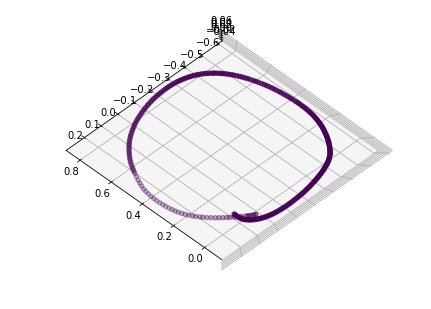

In [317]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=90, azim=134)

ax.scatter(sk_rnn0, sk_rnn1, sk_rnn2, c=[random.randrange(1, 100)]*len(sk_rnn0),marker='o')

plt.show()

In [318]:
# -ax.get_proj() # exploiting the projection matrix

In [319]:
# import mpl_toolkits
# s = mpl_toolkits.mplot3d.proj3d.proj_transform(sk_rnn0, sk_rnn1, sk_rnn2, ax.get_proj())

260


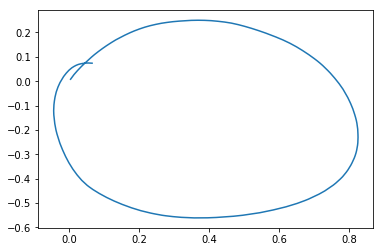

In [320]:
plt.plot(sk_rnn0, sk_rnn1)
print(len(sk_rnn0))

In [330]:
# world coordinates to dx and dy for neural network, and scaling accordingly!
final_inp = []
l_x = sk_rnn0[0]
l_y = sk_rnn1[0]
for i in range(1, len(sk_rnn0),10):
    final_inp.append( [ (l_x - sk_rnn0[i])*100, (l_y - sk_rnn1[i])*100, 1, 0, 0])
    l_x = sk_rnn0[i]
    l_y = sk_rnn1[i]
final_inp[-1][3] = 1
final_inp[-1][2] = 0




In [331]:
print(final_inp)

[[-0.40559999999999485, -0.7798999999999889, 1, 0, 0], [-8.7449, -11.848600000000008, 1, 0, 0], [-13.634300000000005, -9.355199999999986, 1, 0, 0], [-17.423099999999998, -2.0698000000000105, 1, 0, 0], [-17.6589, 6.192900000000012, 1, 0, 0], [-9.397200000000005, 6.860899999999992, 1, 0, 0], [-7.824299999999996, 9.67579999999999, 1, 0, 0], [-5.067900000000003, 11.258400000000002, 1, 0, 0], [-2.0890999999999993, 11.653400000000014, 1, 0, 0], [1.0345000000000049, 10.741, 1, 0, 0], [4.675099999999999, 9.518499999999985, 1, 0, 0], [8.4283, 7.3515, 1, 0, 0], [11.297699999999999, 4.807100000000009, 1, 0, 0], [12.613999999999997, 2.4998999999999993, 1, 0, 0], [12.477599999999999, 0.17650000000000166, 1, 0, 0], [10.653700000000004, -2.3895, 1, 0, 0], [8.56349999999999, -4.287099999999999, 1, 0, 0], [6.661100000000008, -5.29980000000001, 1, 0, 0], [4.825099999999994, -7.112199999999991, 1, 0, 0], [3.3016000000000045, -8.603899999999998, 1, 0, 0], [2.0101999999999953, -9.101099999999995, 1, 0, 0],

0
[]


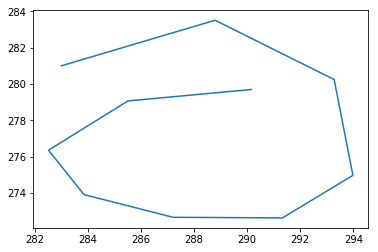

In [18]:
draw_strokes([[0,0,1,0,0],[-5.7915,-2.509499999999998,1,0,0],[-4.4864,3.2636,1,0,0],[-0.7073000000000009,5.278099999999997,1,0,0],[2.6576000000000004,2.343799999999996,1,0,0],[4.1219,-0.034999999999996145,1,0,0],[3.3531999999999993,-1.249699999999998,1,0,0],[1.3353000000000004,-2.4428000000000005,1,0,0],[-2.9894000000000003,-2.7140000000000053,1,0,0],[-4.657199999999999,-0.6313000000000013,1,0,0]]) # voila!

In [19]:
print(len([[0,0,1,0,0],[-5.7915,-2.509499999999998,1,0,0],[-4.4864,3.2636,1,0,0],[-0.7073000000000009,5.278099999999997,1,0,0],[2.6576000000000004,2.343799999999996,1,0,0],[4.1219,-0.034999999999996145,1,0,0],[3.3531999999999993,-1.249699999999998,1,0,0],[1.3353000000000004,-2.4428000000000005,1,0,0],[-2.9894000000000003,-2.7140000000000053,1,0,0],[-4.657199999999999,-0.6313000000000013,1,0,0]]))

10


In [333]:
print(final_inp)

[[-0.40559999999999485, -0.7798999999999889, 1, 0, 0], [-8.7449, -11.848600000000008, 1, 0, 0], [-13.634300000000005, -9.355199999999986, 1, 0, 0], [-17.423099999999998, -2.0698000000000105, 1, 0, 0], [-17.6589, 6.192900000000012, 1, 0, 0], [-9.397200000000005, 6.860899999999992, 1, 0, 0], [-7.824299999999996, 9.67579999999999, 1, 0, 0], [-5.067900000000003, 11.258400000000002, 1, 0, 0], [-2.0890999999999993, 11.653400000000014, 1, 0, 0], [1.0345000000000049, 10.741, 1, 0, 0], [4.675099999999999, 9.518499999999985, 1, 0, 0], [8.4283, 7.3515, 1, 0, 0], [11.297699999999999, 4.807100000000009, 1, 0, 0], [12.613999999999997, 2.4998999999999993, 1, 0, 0], [12.477599999999999, 0.17650000000000166, 1, 0, 0], [10.653700000000004, -2.3895, 1, 0, 0], [8.56349999999999, -4.287099999999999, 1, 0, 0], [6.661100000000008, -5.29980000000001, 1, 0, 0], [4.825099999999994, -7.112199999999991, 1, 0, 0], [3.3016000000000045, -8.603899999999998, 1, 0, 0], [2.0101999999999953, -9.101099999999995, 1, 0, 0],

In [36]:
# reply after talking to nn
# http://localhost:8000/simple_predict?strokes=[[-0.40559999999999485,%20-0.7798999999999889,%201,%200,%200],%20[-8.7449,%20-11.848600000000008,%201,%200,%200],%20[-13.634300000000005,%20-9.355199999999986,%201,%200,%200],%20[-17.423099999999998,%20-2.0698000000000105,%201,%200,%200],%20[-17.6589,%206.192900000000012,%201,%200,%200],%20[-9.397200000000005,%206.860899999999992,%201,%200,%200],%20[-7.824299999999996,%209.67579999999999,%201,%200,%200],%20[-5.067900000000003,%2011.258400000000002,%201,%200,%200],%20[-2.0890999999999993,%2011.653400000000014,%201,%200,%200],%20[1.0345000000000049,%2010.741,%201,%200,%200],%20[4.675099999999999,%209.518499999999985,%201,%200,%200],%20[8.4283,%207.3515,%201,%200,%200],%20[11.297699999999999,%204.807100000000009,%201,%200,%200],%20[12.613999999999997,%202.4998999999999993,%201,%200,%200],%20[12.477599999999999,%200.17650000000000166,%201,%200,%200],%20[10.653700000000004,%20-2.3895,%201,%200,%200],%20[8.56349999999999,%20-4.287099999999999,%201,%200,%200],%20[6.661100000000008,%20-5.29980000000001,%201,%200,%200],%20[4.825099999999994,%20-7.112199999999991,%201,%200,%200],%20[3.3016000000000045,%20-8.603899999999998,%201,%200,%200],%20[2.0101999999999953,%20-9.101099999999995,%201,%200,%200],%20[0.4956999999999989,%20-8.57620000000001,%201,%200,%200],%20[-0.9997999999999951,%20-7.450899999999994,%201,%200,%200],%20[-2.1202000000000054,%20-5.573899999999998,%201,%200,%200],%20[-2.6740999999999904,%20-3.555700000000006,%201,%200,%200],%20[-3.0095000000000094,%20-1.3311000000000073,%200,%201,%200]]
reply_skrnn = [[-48.91658526173597,3.9575275321791663,1,0,0],[-4.279974223875543,3.0421221177356936,1,0,0],[-18.535514419879856,12.583154861744836,1,0,0],[-7.359458737421364,6.858389048627128,1,0,0],[-3.119774411047576,4.211454288828207,1,0,0],[-0.8755949407676524,3.754044933201731,1,0,0],[4.7522147219859505,3.6727032375997286,1,0,0],[12.35908591393225,1.4242105210767582,1,0,0],[7.126312055878916,-0.05983387948917112,0,1,0],[11.64779219853031,-33.113511051227974,1,0,0],[0.2863851715337283,-0.0004211294694613907,1,0,0],[-0.8368108273228467,1.3647494746452002,1,0,0],[-2.927285786402733,2.1110801798700556,1,0,0],[0.49586182265656936,1.0136215419281671,1,0,0],[1.9083390134228169,0.21612044301527172,1,0,0],[2.4035877577190092,0.0007642852363166592,1,0,0],[1.7655229838959732,-1.4240895714766102,1,0,0],[-0.6858861954414464,-3.214816658922567,1,0,0],[-0.8171644982613926,-0.6123001487481796,1,0,0],[-1.5526037300513178,0.07302563799307327,1,0,0],[-0.9483556076983399,0.8684161030071582,1,0,0],[-0.09401287855209778,1.2030148465049482,1,0,0],[1.6416655929546227,0.5178369648464431,1,0,0],[2.2207853901950165,-1.2264197030591775,1,0,0],[0.0037661766182910733,-0.9252689200840464,1,0,0],[-2.5839274573675937,1.143998798288199,1,0,0],[-0.8679049088736611,1.567388901721916,1,0,0],[-0.49819755340707905,-0.9424521703282631,1,0,0],[1.240385537173559,-0.6826265172580737,1,0,0],[0.11698320103582059,1.9960554749747312,1,0,0],[0.2800630334975859,1.3113124303060746,0,1,0],[33.709510618066645,33.07229047097877,1,0,0],[1.5220565038618832,3.3630427100335845,1,0,0],[3.5793253656270485,3.910425872647739,1,0,0],[13.34777252483003,8.735948105793003,1,0,0],[8.31359004356775,3.651885812130856,1,0,0],[12.32841264264402,3.1819808915370653,1,0,0],[13.496293717832478,1.6805532276792654,1,0,0],[26.21053077287822,-0.3131741804629417,1,0,0],[14.071525817463307,-2.5780579026459467,1,0,0],[14.535204981010097,-6.177125645536984,1,0,0],[8.552541310600349,-5.718675133860469,1,0,0],[12.612766929803358,-12.149550634296844,1,0,0],[3.5324963526009734,-6.804583996616552,1,0,0],[0.9516237941468846,-3.3131146400492812,1,0,0],[0.1960938533825214,-8.152412143520026,1,0,0],[-1.937473694833528,-6.516347889505092,1,0,0],[-3.9545981155433823,-5.889213195517249,1,0,0],[-18.525659769522015,-11.460945537494778,1,0,0],[-17.269181088600817,-3.8709334057361966,1,0,0],[-10.463199270613039,0.00038938823592343135,1,0,0],[-18.510937421740696,2.701646628652307,1,0,0],[-11.22665223399791,3.0954215153767946,1,0,0],[-6.590486649381833,3.1591682490415076,1,0,0],[-8.300703580776457,5.355993974071001,1,0,0],[-9.181970837053447,8.932707601948357,0,1,0],[-18.4738320480758,-2.218778396658677,1,0,0],[2.2712572107442375,-0.5521182484503113,1,0,0],[14.845156573747065,-5.356337133482055,1,0,0],[21.575812625395084,-4.5737004788802516,1,0,0],[15.993706216260374,-1.1340385714663102,1,0,0],[20.600137156390083,1.0864335507317628,1,0,0],[8.675733629559023,2.237963970563785,1,0,0],[9.082386584950635,4.724328812712591,1,0,0],[3.030067743210755,2.8841301925145015,1,0,0],[2.715287001700741,5.616554886852705,1,0,0],[0.8772061995836029,4.549398872054446,1,0,0],[-1.813543096636178,7.4969575991803294,1,0,0],[-8.562696520993006,9.349997576683553,1,0,0],[-24.7868241331099,10.607106134502741,1,0,0],[-11.808590973483197,2.368202279603368,1,0,0],[-17.079966685148396,0.0003587778348390349,1,0,0],[-6.772649283401021,-1.0285727748214013,1,0,0],[-13.142992851557182,-4.969871704217838,1,0,0],[-10.382589677683955,-7.018756599088223,1,0,0],[-6.454421227416317,-7.180671382226705,1,0,0],[-2.8272294888648943,-5.343662641217396,1,0,0],[-0.24133799995156813,-3.7027338981956865,1,0,0],[1.394881544976509,-2.2434922963503556,1,0,0],[7.110276100368309,-3.3831286875481736,1,0,0],[4.459219529134484,-0.585746914727964,1,0,0],[3.6850898235803715,-1.378094791950945,0,1,0],[12.834972543383968,-1.0330316816874174,1,0,0],[3.4609177317922706,-3.983171949223394,1,0,0],[17.82938706140474,-16.384534748044018,1,0,0],[12.26933691072045,-11.603333557869723,1,0,0],[8.111830925894989,-9.582329352149884,1,0,0],[8.024576478758501,-7.572655585379888,1,0,0],[6.140651913855737,-4.253337066782895,1,0,0],[2.5734226097440884,-0.9863604397524176,1,0,0],[1.5161318150397012,4.121939684850445,1,0,0],[-0.6789642557856992,9.635682077432845,1,0,0],[-2.1790957976066845,8.750408816284313,1,0,0],[-7.389668876535522,15.891572203219505,1,0,0],[-4.394927774612727,5.797388533693417,1,0,0],[-14.736410455634434,14.947307389527962,0,1,0],[-43.482821380550675,-23.794703122055097,1,0,0],[-1.5902451310332297,-3.261402650734507,1,0,0],[0.9119396795770187,-12.89934341880076,1,0,0],[2.5055728263066688,-7.922020380586016,1,0,0],[6.433082413881341,-12.178997393372374,1,0,0],[6.129133930445884,-8.215582513460388,1,0,0],[3.1550385094336564,-1.4274416337324065,1,0,0],[2.4318811860827934,2.6614729701566207,1,0,0],[2.8325327150921042,10.804719936425586,1,0,0],[1.5579913171402653,17.07272934588575,1,0,0],[-0.7344453303935324,9.124591778136038,1,0,0],[-6.859887947838906,12.56584595477893,0,1,0],[26.426536548237664,53.79079432104627,1,0,0],[-3.0671364724427876,15.499071605902612,1,0,0],[-1.4983067982101335,4.053135469253246,1,0,0],[-16.130032341570203,4.930080458895271,1,0,0],[-1.140374336749516,0.9898505575704711,0,1,0],[15.177756084542679,-6.207725661516545,1,0,0],[-2.6994724546563424,10.050691441349624,1,0,0],[-1.7481703960213637,3.4927807902862686,0,1,0],[6.33603995156215,-13.150530619614507,1,0,0],[2.4615085230784826,5.789972886533698,1,0,0],[3.0231142744219253,4.128455713566745,0,1,0],[22.43322561217526,-26.331780794211795,0,1,0],[-6.609106858119986,-35.12951507706512,0,0,1]]
dd = [[2.167897078275968,2.5638640293345247,1,0,0],[0.881856161871453,12.948602330006015,1,0,0],[-1.0834514820360166,3.872235173842843,1,0,0],[-2.735284989947278,2.9023845090355644,1,0,0],[-3.6868493815175976,1.9156937712973938,1,0,0],[-8.93930998224898,1.1081809816071444,0,1,0],[0.7615618629449807,-19.8829263369607,1,0,0],[5.177428389226201,0.36285240883367026,1,0,0],[19.344779911371685,5.588789219496796,1,0,0],[10.938080181538979,3.9853706258104764,1,0,0],[7.136710643631952,1.9654563479030913,1,0,0],[9.320205369637636,4.022895292275912,1,0,0],[5.406610807841139,3.436541770201594,1,0,0],[13.870649756199064,9.223963624735763,1,0,0],[11.158321199782492,9.670237340640856,1,0,0],[-2.5606200615635926,0.40912899079086723,1,0,0],[-13.898140986192903,-4.662952651212486,1,0,0],[-28.756153550388348,-0.9679719959190031,1,0,0],[-26.861182432118266,-2.4962629660881714,1,0,0],[-12.511744160535999,-4.144762267293834,0,1,0],[-4.399005429978795,-24.5642378860444,1,0,0],[0.7060700877160379,-2.0851571738405945,1,0,0],[3.662076061659471,-1.1188957778157758,1,0,0],[2.3970918187938173,-1.6858668257647125,1,0,0],[1.3766605857371232,-1.911544550598338,1,0,0],[-1.5847206196130403,1.3417544763143525,1,0,0],[-3.3559441371307024,2.2621279077818546,1,0,0],[-1.086913970602524,-0.3441383060252686,1,0,0],[-1.2044621535181614,-0.9945475877268244,0,1,0],[-11.957451433409688,33.34213660726384,1,0,0],[-0.0020046435112433393,1.8400346731847885,1,0,0],[-0.8314774970020465,2.3194488477729593,1,0,0],[-0.8032501027741448,6.842126691342515,1,0,0],[-2.708975793087163,7.3145396642403995,1,0,0],[-6.898650553428705,8.188374251994416,1,0,0],[-20.82206425949628,11.154033314721081,1,0,0],[-8.339799416268404,2.4527591676306932,1,0,0],[-17.542781142789934,-0.0002968036056535741,1,0,0],[-16.458858440283713,-5.02468090083624,0,1,0],[78.16720767915648,-34.159819520863934,1,0,0],[-1.435495100773761,0.2514292576254892,1,0,0],[-7.768834426234195,0.9574176697046182,1,0,0],[-23.37148778984914,6.365460365053584,1,0,0],[-13.092189402837377,4.518925407926458,1,0,0],[-14.760263047396544,7.056632101517194,1,0,0],[-6.699125159525484,4.874411585510758,1,0,0],[-14.688433419162696,12.313000792897299,1,0,0],[-14.404155253358635,7.2985360207759555,1,0,0],[-1.8512328090831427,1.765432444809805,1,0,0],[-2.533482073197281,1.0231499282355039,0,1,0],[38.46547707619113,-6.613365802988126,1,0,0],[-0.004228463185164769,10.312239171900364,1,0,0],[-2.3411766825446483,17.9769154513562,1,0,0],[-1.8165686724908174,5.860194945701258,1,0,0],[-5.516726541967566,14.753996752148526,1,0,0],[-3.9701162574009254,7.632216378229271,0,1,0],[10.753230183210167,-19.169610573936104,1,0,0],[2.0382970342723326,3.77618579617079,1,0,0],[10.730428882705642,10.123513298408257,0,1,0],[-13.131231590726848,-13.926893299001218,1,0,0],[0.7255916662279367,4.416458569959642,0,1,0],[18.401404313855345,-56.531209882263255,1,0,0],[-0.008779856386872644,21.433103639814245,1,0,0],[2.14566318152599,12.9035054606195,1,0,0],[3.194331026150957,11.524472976611243,1,0,0],[0.6060310279640321,4.91689790780651,1,0,0],[-1.3941949947848964,0.3695757823587517,1,0,0],[-4.12064901250407,5.059509531694952,1,0,0],[0.1660575212813289,0.5797078738195063,1,0,0],[1.624398522979561,-1.3869879266295237,0,1,0],[0.7545567777189621,-8.913105896593262,1,0,0],[1.4905776090143836,0.7732185306059144,0,1,0],[1.2787847431414854,-1.4797675152398586,1,0,0],[2.873482050731174,3.054652391502845,1,0,0],[2.1632333549252625,0.793624331276679,1,0,0],[1.933655056965502,1.4735715219838597,0,1,0],[-43.79462513717454,-75.52866940647733,1,0,0],[-0.2895005044704578,-0.09999442502161401,1,0,0],[-5.667755531036824,-4.038074630651487,1,0,0],[-23.883812521752294,-14.85138228162532,1,0,0],[-17.541397349159812,-8.767392912886239,1,0,0],[-19.748761903402237,-6.632977882721214,1,0,0],[0.11807492250616271,8.122177780134392,1,0,0],[4.592953656897546,8.039681571582374,1,0,0],[3.1553930561840913,3.5040010472205894,1,0,0],[4.372210309170092,3.2913919499541744,1,0,0],[6.992306592012384,3.6618699806633193,1,0,0],[6.073201343360834,1.9197532332837097,1,0,0],[10.267147423094642,1.4868799638531083,1,0,0],[6.734700823849066,2.3816498344540524,1,0,0],[4.22181983355455,0.0006721562075632999,1,0,0],[5.409715812136302,1.8145396916242102,1,0,0],[9.185615604719725,1.578044734708664,0,1,0],[-1.4349675218753037,4.684017623443729,0,0,1]]
ii  = [[0.7580000000000003, 0.13410000000000366,1,0,0],[4.734000000000002, 4.698599999999997,1,0,0],[2.865799999999996, 8.565099999999992,1,0,0],[-0.2202999999999955, 9.605000000000018,1,0,0],[-3.1137000000000024, 9.297299999999996,1,0,0],[-5.8302, 8.122699999999995,1,0,0],[-8.169500000000001, 5.95460000000001,1,0,0],[-9.7182, 3.9430999999999994,1,0,0],[-13.663699999999999, 0.4544999999999799,1,0,0],[-11.3796, -4.442199999999996,1,0,0],[-8.38250000000001, -9.027399999999997,1,0,0],[-3.299799999999986, -11.168599999999994,1,0,0],[3.142299999999998, -10.64020000000001,1,0,0],[10.378799999999998, -9.966199999999992,1,0,0],[10.905699999999996, -4.534799999999994,1,0,0],[10.765600000000001, -1.410900000000015,1,0,0],[8.793000000000001, -0.006599999999989947,1,0,0],[8.4486, 1.024500000000006,1,0,0],[6.365899999999999, 3.733900000000001,1,0,0]]


12
[25, 14, 9, 10, 11, 6, 3, 2, 9, 2, 4, 17]


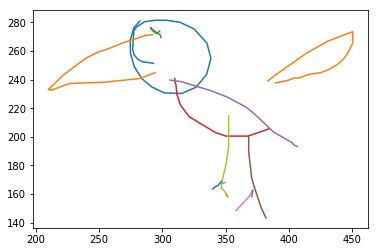

In [37]:
draw_strokes(ii + dd)

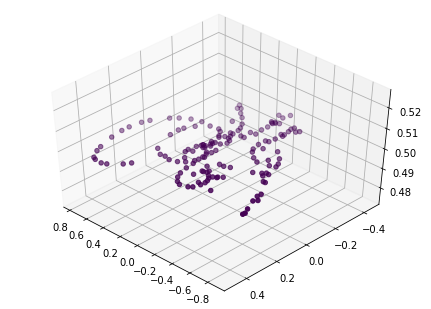

In [29]:
# dx and dy to world coordinates for neural network, and scaling accordingly!
# final_inp is given
reply_skrnn_full = ii + [[-1.2985526260960272,-7.175731986562554,1,0,0],[0.882820499806603,-12.414497265174708,0,1,0],[0.04470427346341884,18.170929544118117,1,0,0],[-0.6060574028308717,-1.0592158295988392,0,1,0],[-3.3852321990893457,-2.7846481326441808,1,0,0],[-0.1289824855772785,-0.05102488350498042,1,0,0],[-0.26821154262310215,-1.0294742489466242,1,0,0],[-1.7407509077668735,-2.2054701332409117,1,0,0],[-1.2532512670596014,-4.5589883244019695,0,1,0],[5.808402718923841,7.907520096689219,1,0,0],[1.5827709986553364,-1.314612782217689,1,0,0],[6.168953354361089,-2.534225918867828,1,0,0],[21.179043216400725,-3.83869640481844,1,0,0],[4.591865842607605,0.00835187102651093,1,0,0],[5.053633189115743,1.3138914064718121,1,0,0],[18.2248363536447,3.7714895897707055,1,0,0],[6.108127533860585,2.3139452398154856,1,0,0],[2.4148045450908655,1.4998846439418136,1,0,0],[-1.2254683950741565,7.02370573815312,1,0,0],[-1.8781068333355289,2.6418641766399302,1,0,0],[-4.904700754492172,3.747234826276971,1,0,0],[-8.81339293306264,4.187589166404789,1,0,0],[-16.28800294476765,3.9976874089111694,1,0,0],[-16.242475021191442,0.9736355083978753,1,0,0],[-4.934098652599517,-0.6040577691351828,1,0,0],[-31.062846755455308,-8.53592684051249,1,0,0],[-8.45567010121215,-4.983784948096041,1,0,0],[-4.454828701146685,-4.844663354404786,1,0,0],[-1.1463541989737043,-2.9889876797504886,1,0,0],[0.8509724175870574,-5.674666470440101,1,0,0],[8.52938733970543,-12.918518267764824,1,0,0],[8.33939477366799,-3.110805767308652,1,0,0],[11.113567789672594,-0.6073768106065057,1,0,0],[6.996084254801622,1.3617757115870897,1,0,0],[5.0105938620308805,2.374945489061383,1,0,0],[3.6934354333552606,3.656951341038454,1,0,0],[0.7861217192803696,2.216764349925858,1,0,0],[-0.16316815838475382,2.7114964895343343,1,0,0],[-1.2794089995501947,2.989704098910222,0,1,0],[-10.977383509165286,-2.380015405084171,1,0,0],[-3.8421711122315862,-2.7224369708632845,1,0,0],[-6.478550066277659,-9.245431212658499,1,0,0],[-11.52798501515795,-14.822998763939195,1,0,0],[-3.6624159238725444,-3.27890290532683,1,0,0],[-9.452002737855924,-5.095645716727318,1,0,0],[-4.413476191554471,-1.1257207142963153,1,0,0],[-7.473923517194291,0.3532564708723037,1,0,0],[-3.081170966303652,0.8314907172600043,1,0,0],[-6.0807120144072755,5.203400466533662,1,0,0],[-2.567914425035847,3.7176979256252225,1,0,0],[-4.865752040659114,9.646756296207244,1,0,0],[-1.9057451682362831,7.506449161407294,1,0,0],[0.0005111204060436893,4.723321164291586,1,0,0],[1.7722159623943436,7.022266749658011,1,0,0],[2.629628899083261,3.992434662093596,1,0,0],[8.94191629744757,7.844528841870806,1,0,0],[5.509053388092359,3.1223323044718687,1,0,0],[8.246742118906885,3.125717288582579,1,0,0],[9.476633268354052,1.711372061281154,1,0,0],[18.40710098485884,0.4907190312328603,1,0,0],[3.793382569436351,-1.2846035899810764,1,0,0],[4.174136377300169,-3.2412528554788245,0,1,0],[13.043602333935805,6.865879586233032,1,0,0],[3.5911697397431883,-0.002092357305705596,1,0,0],[16.223457445447387,-0.1601157658317531,1,0,0],[7.388847701247297,-1.3695473346530365,1,0,0],[15.784095390415075,-6.078409098752189,1,0,0],[6.5485103015157735,-3.249938112587817,1,0,0],[9.161865572377854,-5.964123675895935,1,0,0],[6.608388895569286,-6.179411127899425,1,0,0],[9.983838458408304,-11.204093214681823,1,0,0],[2.457051416293355,-4.238455943223264,1,0,0],[5.332799051581623,-6.585732512770588,1,0,0],[2.7540768201214716,-4.697678463734306,1,0,0],[0.25590018909018786,1.3500771092077868,1,0,0],[-6.016683857470676,11.767294652611874,1,0,0],[-4.703720135104731,4.894436778060117,1,0,0],[-12.07584381512828,8.641316311431455,1,0,0],[-6.533871588401492,3.6088656014896827,1,0,0],[-18.38871792888891,7.177591189574041,1,0,0],[-6.45726538139356,1.7489188721523157,1,0,0],[-7.1680909402361,3.376233967324997,1,0,0],[-2.935665557965136,2.3022483102369606,0,1,0],[-31.4127928304367,3.569860378541335,1,0,0],[-12.308695166764021,8.459990422703163,1,0,0],[-12.27928368341559,10.73485932775344,1,0,0],[-2.4295849197886783,2.7964542999924205,1,0,0],[4.943719546928952,-1.8099351338517686,1,0,0],[5.44817804711778,-3.498675723690354,1,0,0],[5.818937472887665,-2.5247240175109886,1,0,0],[7.441701344908158,-4.3994813370624755,1,0,0],[3.5805629617629786,-3.2379150530217706,1,0,0],[1.5908357723607833,-2.46161732972383,1,0,0],[0.7869585614683451,-3.9373543620821256,1,0,0],[1.3626105202273764,-2.5112863312788134,0,1,0],[7.445647468225305,-13.882983507353485,1,0,0],[0.010466896074427441,-2.875448339599387,1,0,0],[1.164655523753199,-5.2375633631356155,1,0,0],[0.39834158446974527,-7.485774203711752,1,0,0],[1.0314044162741542,-4.988053065571623,1,0,0],[2.2553694601786973,-5.069717439559144,1,0,0],[2.987888292519613,-3.4132910310610782,1,0,0],[4.651338242720866,-2.808045587542883,1,0,0],[4.469694233821135,-1.269185321882121,1,0,0],[7.418132794403338,1.1615146415974067,1,0,0],[2.8239249421391053,1.4361069190270292,1,0,0],[2.0442211705085453,3.73504978678596,1,0,0],[0.3568936929474572,2.669086374125425,1,0,0],[-0.9317606542459892,1.9872850224839547,1,0,0],[-1.909835245858428,2.0445465087186574,1,0,0],[-7.615445333040912,4.618247744943429,1,0,0],[-6.526066936518582,2.4269204878314836,0,1,0],[1.1395098878139545,-9.295581491842787,1,0,0],[11.675849890911508,-3.6211771876668126,1,0,0],[15.716711705037628,-1.2891099002346194,0,1,0],[-26.034692281438794,9.599328866690868,1,0,0],[8.615932628676767,-0.9278279375730729,1,0,0],[3.8869228793652217,0.42311573909829114,1,0,0],[3.1062210301148903,0.8424494958759711,1,0,0],[3.210390123839032,2.2302929049125746,0,1,0],[-17.359926165953063,-2.5557789300504163,1,0,0],[2.641755187808315,0.7537992170994513,1,0,0],[11.445550873430992,0.22169174844498948,0,1,0],[-27.343938479964244,44.95931601899904,1,0,0],[0.24962275483230684,3.96120438275268,1,0,0],[-0.946477797209153,3.8798415568617437,1,0,0],[-2.7862415587758442,0.9774223960000343,1,0,0],[-3.060352921252119,6.907033807089936,0,1,0],[4.654228437726997,-7.624992190396338,1,0,0],[0.7759540456426858,6.987762742612782,1,0,0],[1.6181058143146891,4.19971022551283,0,1,0],[-1.2159396372358375,-9.647918433396603,1,0,0],[1.3248174897156049,-0.6042014276875336,1,0,0],[2.823199192904147,0.9829487586961544,0,1,0],[14.889980447841287,-11.88829706658208,1,0,0],[-0.5118199264289872,9.20835868321566,0,1,0],[-1.211033836922482,-4.277982508997716,1,0,0],[-0.007012222241576316,6.709276044418573,1,0,0],[0.5427321864135692,1.9750259571979407,0,1,0],[1.7820144810015952,-7.852254635905774,1,0,0],[3.6216451793192803,5.4940984058213465,1,0,0],[1.7972791703831386,1.5985831595042024,0,1,0],[-4.7563744698120525,-8.626937512256385,0,0,1]]
sk1_rnn0 = []
sk1_rnn1 = []

l_x = reply_skrnn_full[0][0]/100
l_y = reply_skrnn_full[0][1]/100
for i in range(1, len(reply_skrnn_full)):
    sk1_rnn0.append(l_x - reply_skrnn_full[i][0]/100)
    sk1_rnn1.append(l_y - reply_skrnn_full[i][1]/100)
    l_x = sk1_rnn0[-1]
    l_y = sk1_rnn1[-1]

sk1_rnn0.append(l_x - reply_skrnn_full[i][0]/100)
sk1_rnn1.append(l_y - reply_skrnn_full[i][1]/100)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=45, azim=134)

ax.scatter(sk1_rnn0, sk1_rnn1, [0.5]*len(sk1_rnn0), c=[random.randrange(1, 100)]*len(sk1_rnn0),marker='o')

plt.show()


# From Sketch-RNN to a-painter

In [24]:
# sk1_rnn0, sk1_rnn1 is given, get dx and dy back by reversing the following thing!


In [25]:
a_painter_reply = {}
prev_version = drawing['version']
prev_index = drawing['strokes'][-1]['brush']['index'] #exactly the last brush we used!
prev_brush_color = drawing['strokes'][-1]['brush']['color'] #exactly the last brush we used!
prev_brush_size = drawing['strokes'][-1]['brush']['size'] #exactly the last brush we used!
prev_pressure = 1.0 #drawing['strokes'][-1]['points'][-1]['pressure'] # or simply set it to 0.8
prev_timestamp = drawing['strokes'][-1]['points'][-1]['timestamp']
prev_orientation = drawing['strokes'][-1]['points'][-1]['orientation']

a_painter_reply = {"version":prev_version, "strokes":[],"author":"","brushes":drawing['brushes']} # will be json dumped in paintings folder! # first add strokes from input

# now add reply strokes to it!
i = 0
# cur_orientation = [o+random.uniform(-0.01,0.01)  for o in prev_orientation]
cur_orientation = prev_orientation
prev_z = drawing['strokes'][-1]['points'][-1]['position'][2] # + random.uniform(-0.01, 0.01)
# cur_stroke = copy.deepcopy(drawing['strokes'][-1])
prev_x = drawing['strokes'][-1]['points'][-1]['position'][0]
prev_y = drawing['strokes'][-1]['points'][-1]['position'][1]
cur_stroke = {"brush": {"index": prev_index, "color":prev_brush_color, "size":prev_brush_size} , "points":[] }

while i < len(reply_skrnn_full): # going through each point
    
    if reply_skrnn_full[i][2] == 1: #pen down; continuing a previous stroke
        orient = cur_orientation
#         orient = [o+random.uniform(-0.001,0.001)  for o in cur_orientation]
        pos = [prev_x + sk1_rnn0[i], prev_y + sk1_rnn1[i], prev_z ]#+ random.uniform(-0.001, 0.001)]
        temp_point = {"orientation": orient, "position":pos,"pressure": prev_pressure, "timestamp": prev_timestamp+1}
        cur_stroke["points"].append(temp_point)
    elif reply_skrnn_full[i][3] == 1: #pen up event, start a new stroke
        orient= cur_orientation
        pos = [prev_x + sk1_rnn0[i], prev_y + sk1_rnn1[i], prev_z ]#+ random.uniform(-0.001, 0.001)]
        temp_point = {"orientation":orient, "position":pos,"pressure": prev_pressure, "timestamp": prev_timestamp+1}
        cur_stroke["points"].append(temp_point)
        
        #starting a new stroke
        if i < len(reply_skrnn)-2: #if it ain't the last stroke
            a_painter_reply["strokes"].append(cur_stroke)
            cur_stroke = {"brush": {"index": prev_index, "color":prev_brush_color, "size":prev_brush_size} , "points":[] }
            
#             cur_orientation = [o+random.uniform(-0.01,0.01)  for o in cur_orientation]
#             prev_x = a_painter_reply['strokes'][-1]['points'][-1]['position'][0]
#             prev_y = a_painter_reply['strokes'][-1]['points'][-1]['position'][0]
            prev_z = prev_z# + random.uniform(-0.01, 0.01)
    else: # painting end!
        orient= cur_orientation
        pos = [prev_x + sk1_rnn0[i], prev_y + sk1_rnn1[i], prev_z]# + random.uniform(-0.001, 0.001)]
        temp_point = {"orientation":orient, "position":pos,"pressure": prev_pressure, "timestamp": prev_timestamp+1}
        cur_stroke["points"].append(temp_point)
        a_painter_reply["strokes"].append(cur_stroke)
        break
    i += 1
    prev_timestamp += 1

In [26]:
reply = json.dumps(a_painter_reply)
reply_file = open('paintings/reply.json',"w")
reply_file.write(reply)
reply_file.close()

In [27]:
# from dx,dy of sketch rnn to world coordinates! solely for the purpose of visualizing it in 3D!
sk_rnn0 = []
sk_rnn1 = []
sk_rnn2 = []
uu = 0
vv = 1
zz = 2
orientation = [[],[],[],[]]
for i in range(len(a_painter_reply['strokes'])): # go per stroke
    l0 = a_painter_reply['strokes'][i]['points'][0]['position'][uu]
    l1 = a_painter_reply['strokes'][i]['points'][0]['position'][vv]
    l2 = a_painter_reply['strokes'][i]['points'][0]['position'][zz]
    for j in range(1,len(a_painter_reply['strokes'][i]['points'])): # go per point in that stroke
        sk_rnn0.append([0])
        sk_rnn1.append([0])
        sk_rnn2.append([0])
        sk_rnn2[-1] = a_painter_reply['strokes'][i]['points'][j]['position'][zz] - l2
        sk_rnn0[-1] = a_painter_reply['strokes'][i]['points'][j]['position'][uu] - l0
        sk_rnn1[-1] = a_painter_reply['strokes'][i]['points'][j]['position'][vv] - l1
        orientation[0].append(a_painter_reply['strokes'][i]['points'][j]['orientation'][0])        
        orientation[1].append(a_painter_reply['strokes'][i]['points'][j]['orientation'][1])        
        orientation[2].append(a_painter_reply['strokes'][i]['points'][j]['orientation'][2])        
        orientation[3].append(a_painter_reply['strokes'][i]['points'][j]['orientation'][3])

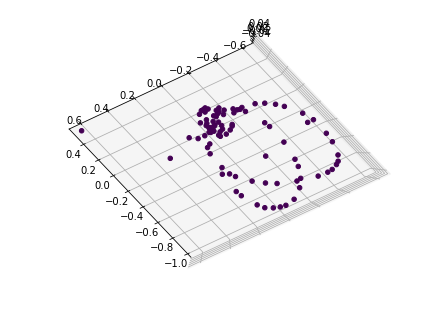

In [28]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=90, azim=145)

ax.scatter(sk_rnn0, sk_rnn1, sk_rnn2, c=[random.randrange(1, 100)]*len(sk_rnn0),marker='o')

plt.show()

In [389]:
[len(i['points']) for i in a_painter_reply['strokes']]

[6, 9, 28, 19, 7, 3, 3, 4]